# 5 Flower Classification with VGG16 with val_acc > 98%
A simple VGG16 transfer learning method with fine turning 

# Importing importent Libraries 

In [1]:

from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D , Activation,Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers
from keras import optimizers
from datetime import datetime
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl
import os
import numpy as np
import pandas as pd
import shutil
from glob import glob
import random
import imageio
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# **Downloading Dataset and splitting into Train and Test Sets**

In [2]:

path = '/kaggle/input/5-flower-types-classification-dataset/flower_images'

rootdir = '/kaggle/working/'
classes_dir = ['Tulip', 'Lilly', 'Lotus', 'Orchid', 'Sunflower'] #total labels
for i in classes_dir:
    if not os.path.exists(rootdir +'/train/' + i):
        os.makedirs(rootdir +'/train/' + i)
    if not os.path.exists(rootdir +'/test/' + i):
        os.makedirs(rootdir +'/test/' + i)

    source = path + '/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    test_ratio = 0.20

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, rootdir +'/train/' + i)

    for name in test_FileNames:
      shutil.copy(name, rootdir +'/test/' + i)



# Train and Test Sets Path Settings

In [3]:
#Setting dataset path for train and test sets 
train_path = rootdir + 'train'
test_path = rootdir + 'test'

# Data Visualization

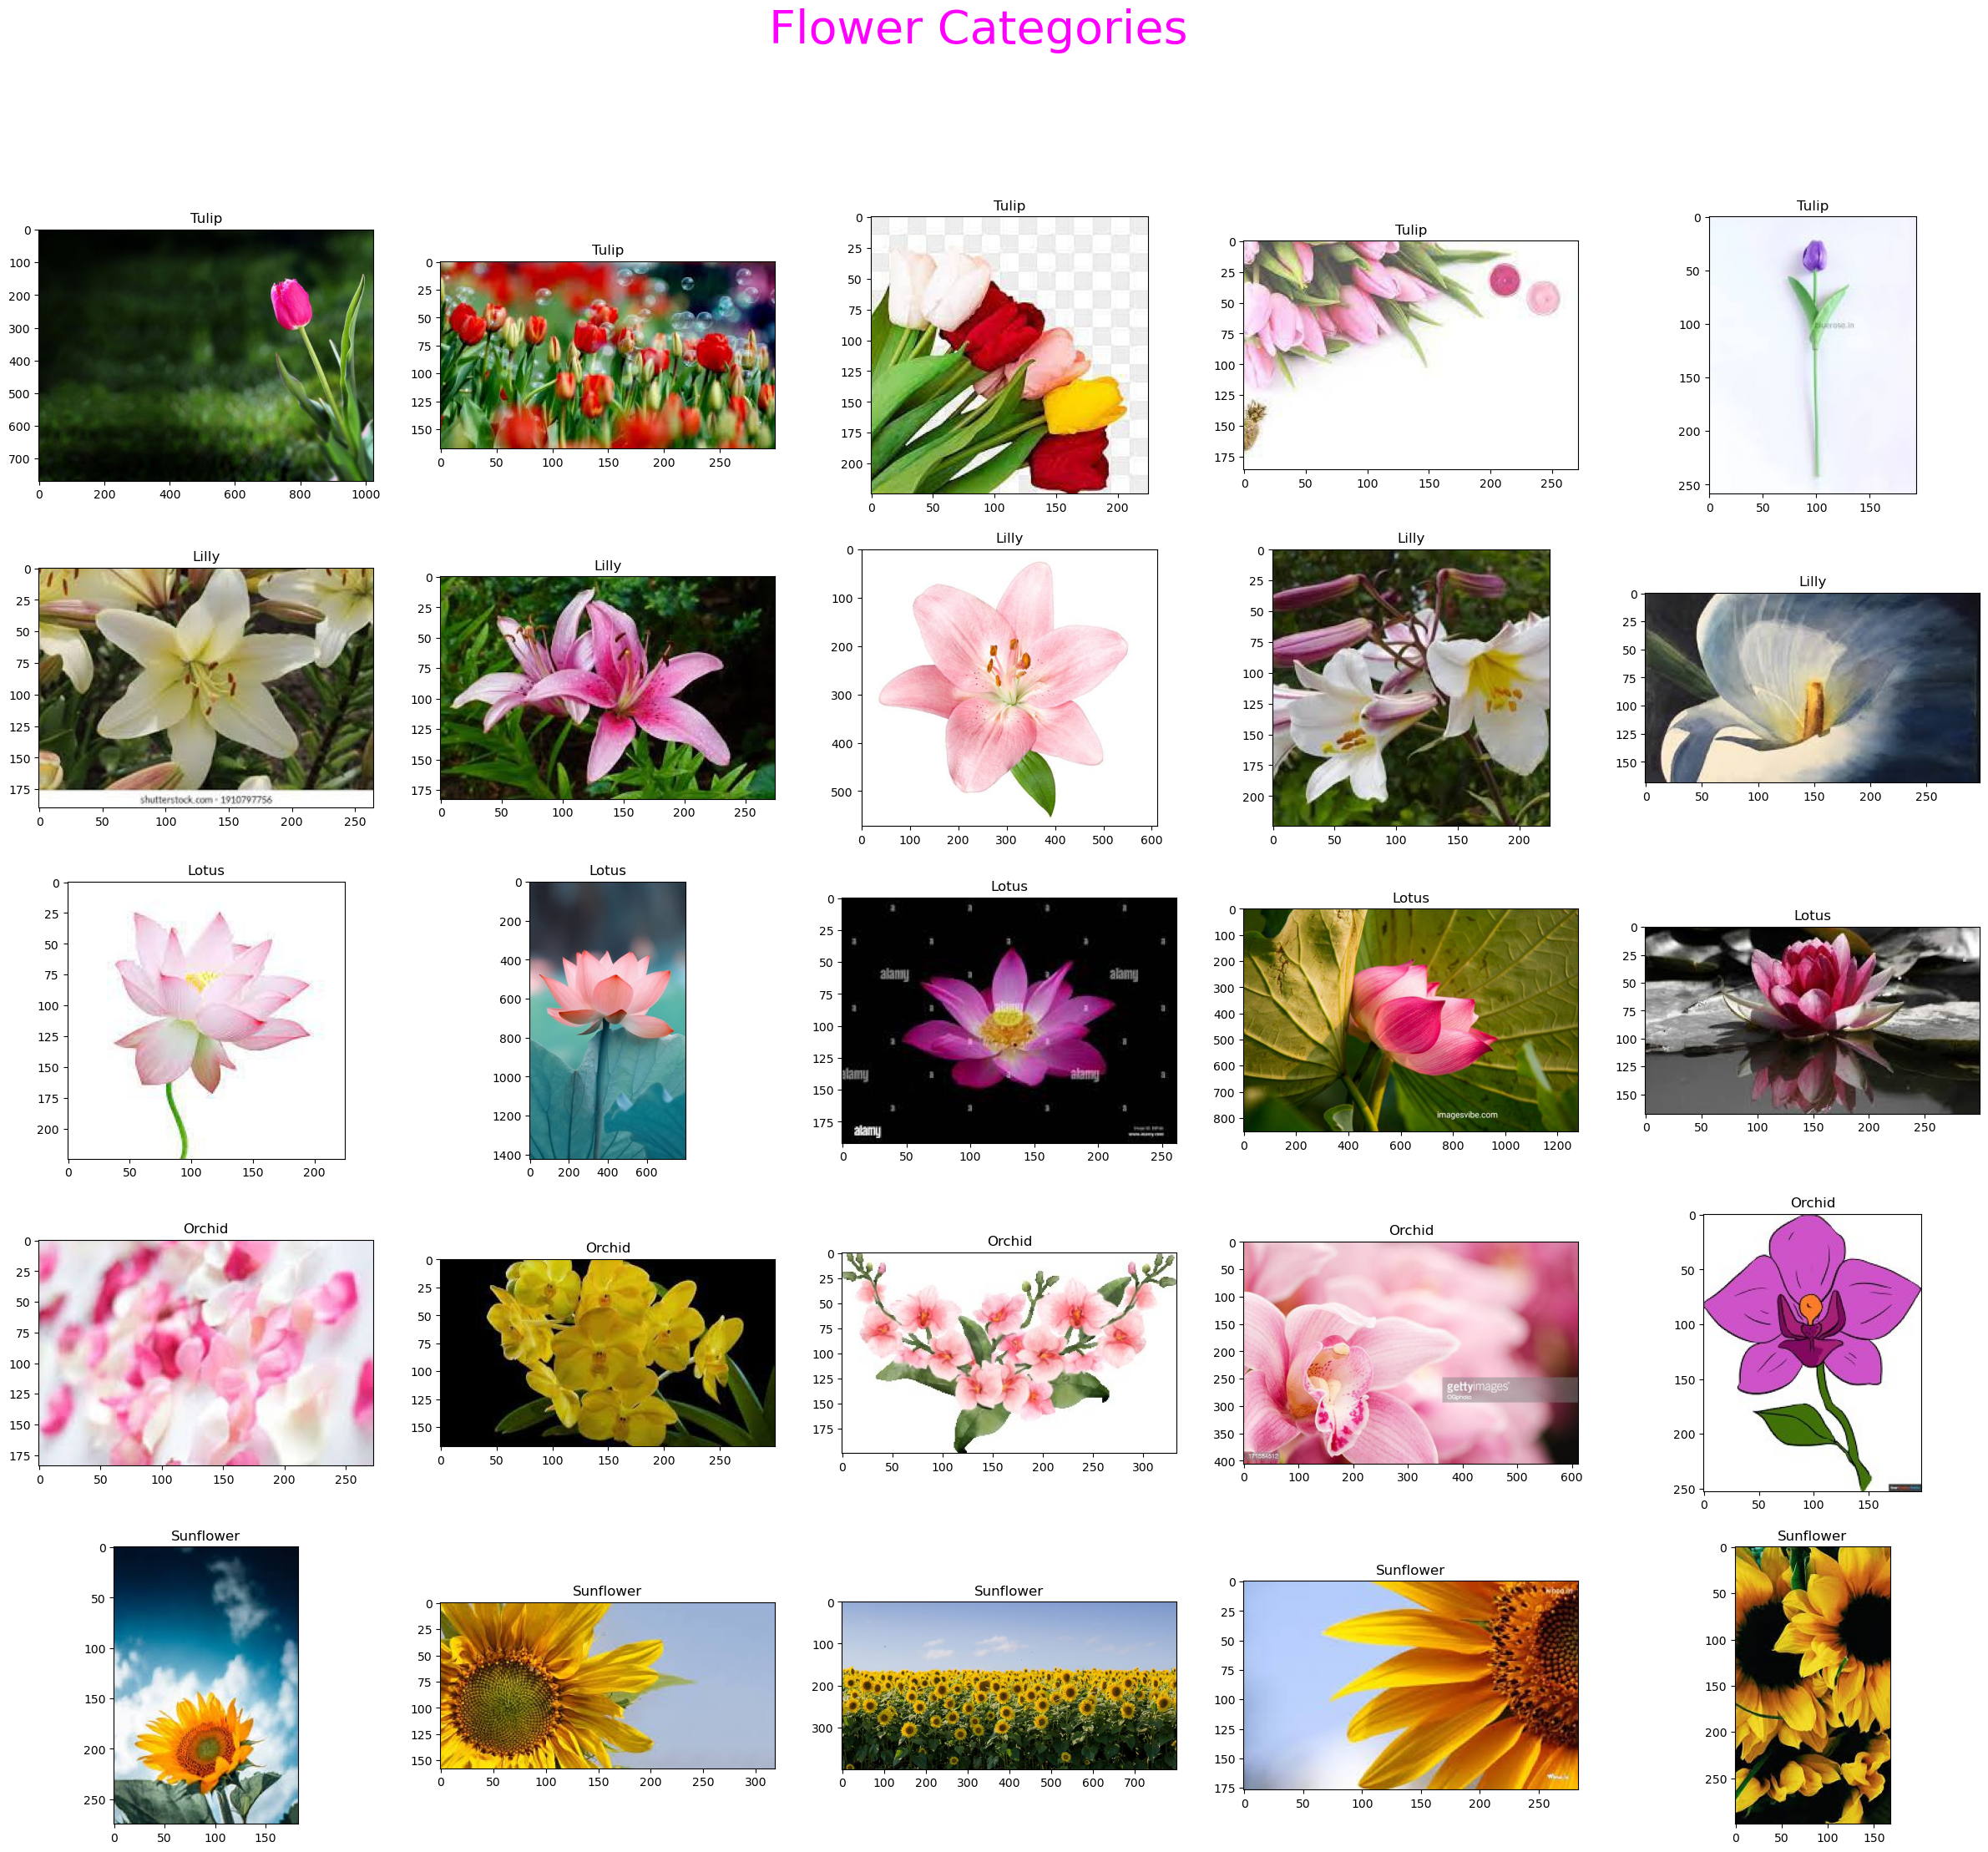

In [4]:
fig, ax = plt.subplots(5,5, figsize=(30,25))
fig.suptitle('Flower Categories',color='magenta',fontsize=40)
for i in range(5):
    for j in range(5):
        im_src = rootdir +'train/' + classes_dir[i] + '/'
        FileNames = os.listdir(im_src)
        im_src = str(im_src + FileNames[j])       
        imag = img.imread(im_src)
        ax[i, j].imshow(imag)
        ax[i, j].set_title(classes_dir[i])

# Data Augmentation of Train and Test Sets

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# test Data Augmentation 
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Train and Test and DataSet Generation

In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


# VGG16 Parameter Setting and Downloading

In [7]:
IMAGE_SIZE = [256, 256, 3]
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


# Freezing the Parameters and Input Checking
 

In [8]:
base_model.input
base_model.trainable = False
#for layer in vgg.layers:
#  layer.trainable = False

# Connecting VGG output with Flatten layer and with Two Dense Layer 

In [9]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


# Compiling and Setting loss function and Optimizer 

In [10]:
adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Start Training and Collecting best points 

In [11]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=15,
                      validation_steps=32,
                      callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/15

Epoch 1: val_loss improved from inf to 1.23329, saving model to mymodel.h5
125/125 - 86s - loss: 2.4614 - accuracy: 0.4667 - val_loss: 1.2333 - val_accuracy: 0.6370 - 86s/epoch - 685ms/step
Epoch 2/15

Epoch 2: val_loss improved from 1.23329 to 0.92377, saving model to mymodel.h5
125/125 - 72s - loss: 1.0595 - accuracy: 0.6970 - val_loss: 0.9238 - val_accuracy: 0.7320 - 72s/epoch - 577ms/step
Epoch 3/15

Epoch 3: val_loss improved from 0.92377 to 0.73715, saving model to mymodel.h5
125/125 - 73s - loss: 0.7931 - accuracy: 0.7510 - val_loss: 0.7372 - val_accuracy: 0.7680 - 73s/epoch - 587ms/step
Epoch 4/15

Epoch 4: val_loss improved from 0.73715 to 0.68091, saving model to mymodel.h5
125/125 - 72s - loss: 0.6699 - accuracy: 0.7865 - val_loss: 0.6809 - val_accuracy: 0.7810 - 72s/epoch - 577ms/step
Epoch 5/15

Epoch 5: val_loss improved from 0.68091 to 0.63833, saving model to mymodel.h5
125/125 - 73s - loss: 0.6007 - accuracy: 0.8010 - val_loss: 0.6383 - val_accuracy: 0.7830

# Do a round of fine-tuning of the entire model
Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.



In [12]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [13]:
adam = optimizers.Adam(1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Importantly
Here although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [14]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=10,
                     # steps_per_epoch=140,
                      validation_steps=32,
                      callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.35081, saving model to mymodel.h5
125/125 - 96s - loss: 0.3327 - accuracy: 0.8835 - val_loss: 0.3508 - val_accuracy: 0.8810 - 96s/epoch - 764ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.35081 to 0.30353, saving model to mymodel.h5
125/125 - 85s - loss: 0.2233 - accuracy: 0.9285 - val_loss: 0.3035 - val_accuracy: 0.9160 - 85s/epoch - 681ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 0.30353
125/125 - 85s - loss: 0.1480 - accuracy: 0.9510 - val_loss: 0.3140 - val_accuracy: 0.9010 - 85s/epoch - 678ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.30353
125/125 - 86s - loss: 0.1382 - accuracy: 0.9513 - val_loss: 0.3592 - val_accuracy: 0.8990 - 86s/epoch - 684ms/step
Epoch 5/10

Epoch 5: val_loss improved from 0.30353 to 0.19891, saving model to mymodel.h5
125/125 - 86s - loss: 0.1116 - accuracy: 0.9625 - val_loss: 0.1989 - val_accuracy: 0.9400 - 86s/epoch - 691ms/step
Epoch 6/10

Epoch 6: val_loss did not 

# Plotting the Accuracy of the Model

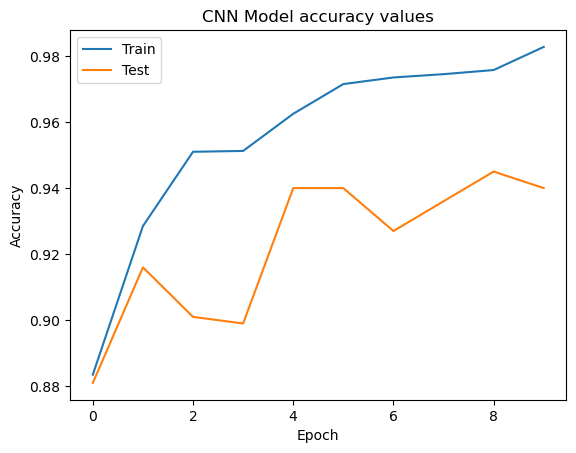

In [15]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plotting the Loss values of the Model

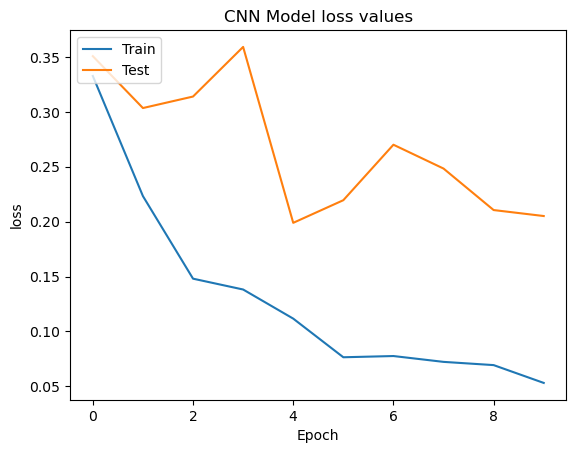

In [16]:
_# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('CNN Model loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Importent Note
IF you find any difficulty feel free to ask me 
After 10 epochs, fine-tuning gains us a nice improvement here.

